## Learn model
## Content
  * Load data
  * Select features
  * Learning
    * linear
    * lasso
    * ridge
    * elastic net
    * Xgboost
    * MLP

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
import warnings
import sklearn.linear_model as linear_model
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
MONGODB_URL = os.environ['MONGODB_URI']
client = MongoClient(MONGODB_URL)
db = client.get_default_database()

In [3]:
data = db["notebook"].find({})
full_frame = pd.DataFrame(list(data))
full_frame.drop(columns=["_id"], inplace=True)
full_frame.shape

(2617, 80)

### Select features

In [4]:
features = [
    'Neighborhood',
    'GarageFinish',
    'Foundation',
    'MasVnrType',
    'GarageType',
    'MSSubClass',
    'GrLivArea',
    'TotalBsmtSF',
    'GarageCars',
    'BsmtQual',
    'YearBuilt',
    'YearRemodAdd',
    'FireplaceQu',
    'FullBath',
    'BsmtFinSF1',
    'MasVnrArea']

to_log_transform = ['GrLivArea', 'TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1']

to_pow_transform = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'Neighborhood', 'GrLivArea']

to_boolean_transform = {
    'TotalBsmtSF': {'new_feature_name': 'HasBasement', 'threshold': 0},
    'GarageArea': {'new_feature_name': 'HasGarage', 'threshold': 0},
    '2ndFlrSF': {'new_feature_name': 'Has2ndFloor', 'threshold': 0},
    'MasVnrArea': {'new_feature_name': 'HasMasVnr', 'threshold': 0},
    'WoodDeckSF': {'new_feature_name': 'HasWoodDeck', 'threshold': 0},
    'OpenPorchSF': {'new_feature_name': 'HasPorch', 'threshold': 0},
    'PoolArea': {'new_feature_name': 'HasPool', 'threshold': 0},
    'YearBuilt': {'new_feature_name': 'IsNew', 'threshold': 2000},
}

## Learn model

In [5]:
def log_transformation(frame, feature):
    new_feature_name = new_log_feature_name(feature)
    frame[new_feature_name] = np.log1p(frame[feature].values)

def new_quadratic_feature_name(feature):
    return feature+'2'

def new_log_feature_name(feature):
    return feature+'Log'
    
def quadratic(frame, feature):
    new_feature_name = new_quadratic_feature_name(feature)
    frame[new_feature_name] = frame[feature]**2
    
def boolean_transformation(frame, feature, new_feature_name, threshold):
    frame[new_feature_name] = frame[feature].apply(lambda x: 1 if x > threshold else 0)
    
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def error_mse(actual, predicted):
    actual = (actual)
    predicted = (predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [6]:
added_boolean_columns = [
    'HasBasement', 
    'HasGarage', 
    'Has2ndFloor', 
    'HasMasVnr', 
    'HasWoodDeck',
    'HasPorch', 
    'HasPool', 
    'IsNew']

added_quadratic_columns = list(map(new_quadratic_feature_name, to_pow_transform))

added_log_columns = list(map(new_log_feature_name, to_log_transform))

def transform_before_learn(frame, to_log_transform, to_pow_transform, to_boolean_transform):

    for c in to_log_transform:
        log_transformation(frame, c)

    for c in to_pow_transform:
        quadratic(frame, c)

    for c in to_boolean_transform.keys():
        boolean_transformation(frame, c, to_boolean_transform[c]['new_feature_name'], 
                               to_boolean_transform[c]['threshold']) 


transform_before_learn(full_frame, to_log_transform, to_pow_transform, to_boolean_transform)

df_train = full_frame[:1460]
df_test = full_frame[1460:]

In [7]:
features_full_list = features + added_boolean_columns + added_quadratic_columns + added_log_columns

## Out liars

In [8]:
df_train_cleaned = df_train
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 1299].index)
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 524].index)

### LinearRegression

In [9]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

linear = linear_model.LinearRegression()
linear.fit(X, np.log1p(Y))

Ypred_linear = np.expm1(linear.predict(full_X))
print(error(full_Y, Ypred_linear))
print(error_mse(full_Y, Ypred_linear))

0.14953961060234833
24955.995749895646


#### test dataset

In [10]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(linear.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.14422297781620066
30010.63453512572


### LassoCV

In [11]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

lasso = linear_model.LassoCV()
lasso.fit(X, np.log1p(Y))

Ypred_lasso = np.expm1(lasso.predict(full_X))
print(error(full_Y, Ypred_lasso))
print(error_mse(full_Y, Ypred_linear))

0.2346238945453466
24955.995749895646


#### test dataset

In [12]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(lasso.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.2055730386244748
59276.08156060666


### RidgeCV

In [13]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

ridge = linear_model.RidgeCV()
ridge.fit(X, np.log1p(Y))
Ypred_ridge = np.expm1(ridge.predict(full_X))
print(error(full_Y,Ypred_ridge))
print(error_mse(full_Y, Ypred_ridge))

0.1516270781406908
26347.228993479923


#### test dataset

In [14]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(ridge.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.14328517037958974
30948.552174939854


### ElasticNetCV

In [15]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

elasticNet = linear_model.ElasticNetCV()
elasticNet.fit(X, np.log1p(Y))
Ypred_elasticNet = np.expm1(elasticNet.predict(full_X))
print(error(full_Y,Ypred_elasticNet))
print(error_mse(full_Y, Ypred_elasticNet))

0.23462389468182232
208828.4579571202


#### test dataset

In [16]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(elasticNet.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.20557303786686953
59276.08195962557


### Xgboost

In [17]:
import xgboost as xgb

In [18]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

In [19]:
dtrain = xgb.DMatrix(X, label = np.log(Y))

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

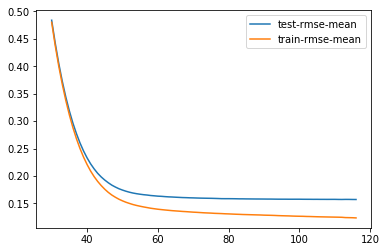

In [20]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [21]:
X_tr, X_val, y_tr, y_val = train_test_split(X, np.log1p(Y), random_state = 42, test_size=0.20)

eval_set = [(X_val, y_val)]

In [22]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_tr, y_tr, eval_metric="rmse", early_stopping_rounds=500, eval_set=eval_set, verbose=True)
# model_xgb.fit(X, np.log1p(Y))

[0]	validation_0-rmse:10.3704
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:9.3327
[2]	validation_0-rmse:8.39882
[3]	validation_0-rmse:7.5584
[4]	validation_0-rmse:6.80394
[5]	validation_0-rmse:6.12399
[6]	validation_0-rmse:5.51288
[7]	validation_0-rmse:4.9627
[8]	validation_0-rmse:4.46863
[9]	validation_0-rmse:4.02225
[10]	validation_0-rmse:3.62142
[11]	validation_0-rmse:3.26235
[12]	validation_0-rmse:2.93762
[13]	validation_0-rmse:2.6461
[14]	validation_0-rmse:2.38395
[15]	validation_0-rmse:2.14747
[16]	validation_0-rmse:1.93605
[17]	validation_0-rmse:1.74482
[18]	validation_0-rmse:1.5731
[19]	validation_0-rmse:1.41889
[20]	validation_0-rmse:1.27902
[21]	validation_0-rmse:1.15403
[22]	validation_0-rmse:1.04163
[23]	validation_0-rmse:0.940346
[24]	validation_0-rmse:0.849784
[25]	validation_0-rmse:0.76916
[26]	validation_0-rmse:0.695593
[27]	validation_0-rmse:0.629321
[28]	validation_0-rmse:0.570332
[29]	validation_0-rmse:0.517292
[30]	validati

[252]	validation_0-rmse:0.119861
[253]	validation_0-rmse:0.119837
[254]	validation_0-rmse:0.119868
[255]	validation_0-rmse:0.119852
[256]	validation_0-rmse:0.119835
[257]	validation_0-rmse:0.119817
[258]	validation_0-rmse:0.119858
[259]	validation_0-rmse:0.119831
[260]	validation_0-rmse:0.119796
[261]	validation_0-rmse:0.11984
[262]	validation_0-rmse:0.119826
[263]	validation_0-rmse:0.119842
[264]	validation_0-rmse:0.119842
[265]	validation_0-rmse:0.119809
[266]	validation_0-rmse:0.119709
[267]	validation_0-rmse:0.119698
[268]	validation_0-rmse:0.119709
[269]	validation_0-rmse:0.119787
[270]	validation_0-rmse:0.119762
[271]	validation_0-rmse:0.119831
[272]	validation_0-rmse:0.119889
[273]	validation_0-rmse:0.119843
[274]	validation_0-rmse:0.119835
[275]	validation_0-rmse:0.119938
[276]	validation_0-rmse:0.119967
[277]	validation_0-rmse:0.119926
[278]	validation_0-rmse:0.119842
[279]	validation_0-rmse:0.119881
[280]	validation_0-rmse:0.119978
[281]	validation_0-rmse:0.119983
[282]	valid

[501]	validation_0-rmse:0.121914
[502]	validation_0-rmse:0.12197
[503]	validation_0-rmse:0.121946
[504]	validation_0-rmse:0.121946
[505]	validation_0-rmse:0.121957
[506]	validation_0-rmse:0.121953
[507]	validation_0-rmse:0.121924
[508]	validation_0-rmse:0.121926
[509]	validation_0-rmse:0.121893
[510]	validation_0-rmse:0.121895
[511]	validation_0-rmse:0.12187
[512]	validation_0-rmse:0.121871
[513]	validation_0-rmse:0.121882
[514]	validation_0-rmse:0.121915
[515]	validation_0-rmse:0.121909
[516]	validation_0-rmse:0.12194
[517]	validation_0-rmse:0.121918
[518]	validation_0-rmse:0.121933
[519]	validation_0-rmse:0.121982
[520]	validation_0-rmse:0.121986
[521]	validation_0-rmse:0.121856
[522]	validation_0-rmse:0.121853
[523]	validation_0-rmse:0.121837
[524]	validation_0-rmse:0.121843
[525]	validation_0-rmse:0.121867
[526]	validation_0-rmse:0.12193
[527]	validation_0-rmse:0.121933
[528]	validation_0-rmse:0.122051
[529]	validation_0-rmse:0.12205
[530]	validation_0-rmse:0.122049
[531]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
xgb_preds = np.expm1(model_xgb.predict(full_X))
print(error(full_Y, xgb_preds))
print(error_mse(full_Y, xgb_preds))

0.10012366667799404
16808.87115859727


#### test dataset

In [24]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(model_xgb.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.14098407319622352
30247.490989111695


## MLP

In [25]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint 
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from keras import backend as K
from keras import losses

Using TensorFlow backend.


In [26]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(42)
np.random.seed(42)

In [27]:
mlp_feed = df_train[features]

In [28]:
scaler = StandardScaler()
scaler.fit(mlp_feed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
X_train = scaler.transform(mlp_feed)

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, np.log(Y), random_state = 3, test_size=0.20)

In [31]:
model = Sequential()
model.add(Dense(10, input_dim = X_train.shape[1],  activation="relu"))
model.add(Dense(1))

adam = optimizers.Adam()

model.compile(loss = losses.mean_squared_error, optimizer = adam)

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                170       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [33]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)  # save best model

In [34]:
hist = model.fit(X_tr, y_tr, batch_size=1, validation_data = (X_val, y_val), callbacks=[monitor, checkpointer], verbose=1, epochs=100)

Train on 1168 samples, validate on 292 samples
Epoch 1/100
1168/1168 [==============================] - 5s 5ms/step - loss: 96.2487 - val_loss: 46.2242
Epoch 2/100
1168/1168 [==============================] - 5s 4ms/step - loss: 19.8563 - val_loss: 9.9934
Epoch 3/100
1168/1168 [==============================] - 5s 4ms/step - loss: 7.3569 - val_loss: 4.5216
Epoch 4/100
1168/1168 [==============================] - 5s 4ms/step - loss: 3.0787 - val_loss: 2.1706
Epoch 5/100
1168/1168 [==============================] - 5s 4ms/step - loss: 1.2227 - val_loss: 1.3521
Epoch 6/100
1168/1168 [==============================] - 5s 4ms/step - loss: 0.5426 - val_loss: 1.0906
Epoch 7/100
1168/1168 [==============================] - 4s 4ms/step - loss: 0.3366 - val_loss: 0.9633
Epoch 8/100
1168/1168 [==============================] - 4s 4ms/step - loss: 0.2441 - val_loss: 0.7654
Epoch 9/100
1168/1168 [==============================] - 5s 4ms/step - loss: 0.1744 - val_loss: 0.7064
Epoch 10/100
1168/1168 

1168/1168 [==============================] - 5s 4ms/step - loss: 0.0276 - val_loss: 0.1538
Epoch 80/100
1168/1168 [==============================] - 5s 4ms/step - loss: 0.0253 - val_loss: 0.1636
Epoch 81/100
1168/1168 [==============================] - 5s 5ms/step - loss: 0.0262 - val_loss: 0.1909
Epoch 82/100
1168/1168 [==============================] - 5s 5ms/step - loss: 0.0267 - val_loss: 0.1716
Epoch 83/100
1168/1168 [==============================] - 5s 4ms/step - loss: 0.0254 - val_loss: 0.1679
Epoch 84/100
1168/1168 [==============================] - 5s 4ms/step - loss: 0.0259 - val_loss: 0.1551
Epoch 85/100
1168/1168 [==============================] - 5s 5ms/step - loss: 0.0257 - val_loss: 0.1517
Epoch 86/100
1168/1168 [==============================] - 5s 5ms/step - loss: 0.0254 - val_loss: 0.1587
Epoch 87/100
1168/1168 [==============================] - 5s 4ms/step - loss: 0.0265 - val_loss: 0.1364
Epoch 88/100
1168/1168 [==============================] - 5s 5ms/step - loss:

In [35]:
model.load_weights('best_weights.hdf5')  # load weights from best model

# Measure accuracy
to_predict = scaler.transform(mlp_feed)
Ypred_mlp = np.exp(model.predict(to_predict))
print(error(df_train['SalePrice'].values,Ypred_mlp))
print(error_mse(df_train['SalePrice'].values, Ypred_mlp))

21.144956171877933
36521526.8672212


#### test dataset

In [36]:
full_test_X = df_test[features]
test_Y = df_test['SalePrice'].values

test_pred = np.exp(model.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

inf
inf
